# Assignment 2

In [72]:

import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

## 1. Part 1:Augmented Reality with Planar Homographies

In [73]:
def extract_frames(video_path, num_frames=0):
    cap = cv2.VideoCapture(video_path)
    frames = []
    if num_frames == 0:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
    else:
        for _ in range(num_frames):
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
    cap.release()
    return frames

### 1.1 Getting Correspondences

The first step is to find the correspondences between the image book (Figure 2.a) and the first frame of the video. Use SIFT descriptor from opencv library to find keypoints in each image and then use the brute force matcher from opencv to get the correspondences. Use the matching way as KNN with size 2, and apply ratio checking between the best 2 matches to filter the good correspondences.
Choose 50 correspondences and plot the book image, the first video frame and the matches as shown below.

In [74]:
book_image = cv2.imread('cv_cover.jpg', cv2.IMREAD_GRAYSCALE)
video_frame = extract_frames('book.mov')[0]
video_frame_gray = cv2.cvtColor(video_frame, cv2.COLOR_BGR2GRAY)

In [75]:
def get_keypoints_and_descriptors(image1, image2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(image1, None)
    kp2, des2 = sift.detectAndCompute(image2, None)
    return kp1, des1, kp2, des2

In [76]:
keypoints_book, descriptors_book, keypoints_video, descriptors_video = get_keypoints_and_descriptors(book_image, video_frame_gray)

In [77]:
def get_best_matches(desc1, desc2, k=2):
    brute_force = cv2.BFMatcher()
    matches = brute_force.knnMatch(desc1, desc2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    selected_matches = good_matches[:50]
    return selected_matches

In [78]:
selected_matches = get_best_matches(descriptors_book, descriptors_video)

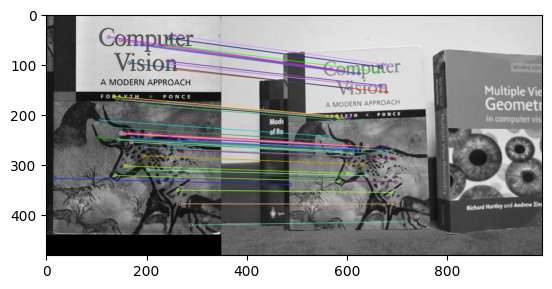

In [79]:
img_matches = cv2.drawMatches(book_image, keypoints_book, video_frame_gray, keypoints_video, selected_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches)
plt.show()

### 1.2 Compute the Homography Parameters

Write a function that takes a set of corresponding image points and computes the associated 3×3 homography matrix H. This matrix transforms any point p in one view to its corresponding homogeneous coordinates in the second view, p’, such that p’ = Hp. Note that p and p’ are both 3D points in homogeneous coordinates. The function should take a list of n >= 4 pairs of corre- sponding points from the two views, where each point is specified with its 2D image coordinates.

We can set up a solution using a system of linear equations Ax = b, where the 8 unknowns of H are stacked into an 8-vector x , the 2n-vector b contains image points from one view, and the 2n × 8 matrix A is filled appropriately so that the full system gives us λp = Hp. There are only 8 unknowns in H because we set H3,3 = 1. Solve for the unknown homography matrix parameters.

Verify that the homography matrix your function computes is correct by mapping the clicked image points from one view to the other, and displaying them on top of each respective image. Be sure to handle homogenous and non-homogenous coordinates correctly.

In [80]:
def compute_homography_matrix(correspondences):
    if len(correspondences) < 4:
        raise ValueError("At least 4 correspondences are required.")
    A = []
    for x, y, xp, yp in correspondences:
        A.append([-x, -y, -1, 0, 0, 0, x * xp, y * xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x * yp, y * yp, yp])
    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    H = V[-1, :].reshape(3, 3)
    return H

In [81]:
def verify_homography(correspondences, H, image1, image2):
    correspondences_array = np.array(correspondences)
    points_first_view = correspondences_array[:, :2]
    points_first_view = np.c_[points_first_view, np.ones(len(correspondences))]
    points_second_view_homogeneous = np.dot(H, points_first_view.T).T
    points_second_view = points_second_view_homogeneous[:, :2] / points_second_view_homogeneous[:, 2:]
    img_first_view = image1.copy()
    img_second_view = image2.copy()
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_first_view, cv2.COLOR_BGR2RGB))
    plt.scatter(points_first_view[:, 0], points_first_view[:, 1], c='red', marker='x')
    plt.title('First View')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_second_view, cv2.COLOR_BGR2RGB))
    plt.scatter(points_second_view[:, 0], points_second_view[:, 1], c='blue', marker='x')
    plt.title('Second View (Mapped)')
    plt.show()

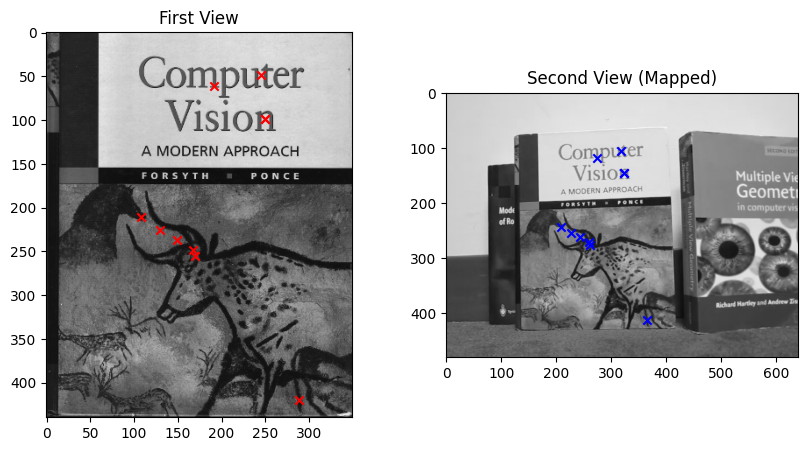

In [82]:
correspondences = []
for i in range(10):
    x, y = keypoints_book[selected_matches[i].queryIdx].pt
    xp, yp = keypoints_video[selected_matches[i].trainIdx].pt
    correspondences.append((x, y, xp, yp))
homography_matrix = compute_homography_matrix(correspondences)
verify_homography(correspondences, homography_matrix, book_image, video_frame_gray)

### 1.3 Calculate Book Coordinates

We need to detect the four corners of the book in the video. This is done by mapping the four corners of the book image (cover) to the first frame in the book video using the homography matrix calculated previously.

In [83]:
def detect_book_corners(homography_matrix):
    book_corners_image = np.array([[1, 1], [book_image.shape[1], 0], [book_image.shape[1], book_image.shape[0]], [0, book_image.shape[0]]], dtype=np.float32)
    book_corners_image_homogeneous = np.c_[book_corners_image, np.ones((4, 1))]
    book_corners_video_homogeneous = np.dot(homography_matrix, book_corners_image_homogeneous.T).T
    book_corners_video = book_corners_video_homogeneous[:, :2] / book_corners_video_homogeneous[:, 2:]
    return book_corners_video

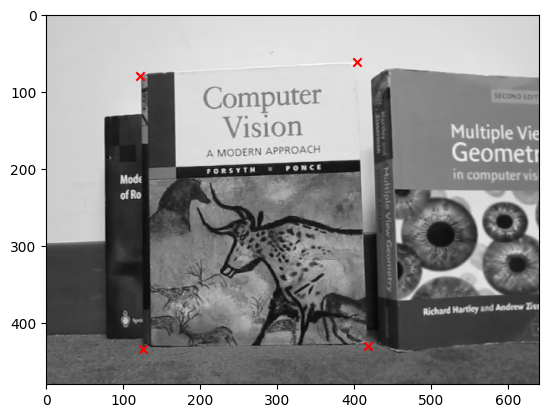

In [84]:
book_corners_video = detect_book_corners(homography_matrix)
plt.imshow(video_frame_gray, cmap='gray')
plt.scatter(book_corners_video[:, 0], book_corners_video[:, 1], c='red', marker='x')
plt.show()

### 1.4 Crop AR Video Frames

The book and the videos we have provided have very different aspect ratios (the ratio of the image width to the image height). You must crop each frame to fit onto the book cover. You should crop each frame such that only its central region is used in the final output.
After Getting the four corners of the book, you can calculate the dimensions of the needed cropped frame.

In [85]:
def crop_frame(video_frame):
    aspect_ratio = book_image.shape[1] / book_image.shape[0]
    height, width, _ = video_frame.shape
    new_width = int(height  * aspect_ratio)
    middle = width // 2
    left = middle - new_width // 2
    right = middle + new_width // 2
    cropped_frame = video_frame[:, left:right]
    return cropped_frame 

In [86]:
source_video = extract_frames('ar_source.mov', 100)[20]
black_bars = 50
source_video = source_video[black_bars:-black_bars,]
cropped_frame = crop_frame(source_video)

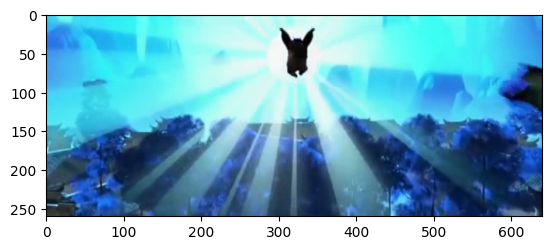

In [87]:
plt.imshow(source_video)
plt.show()


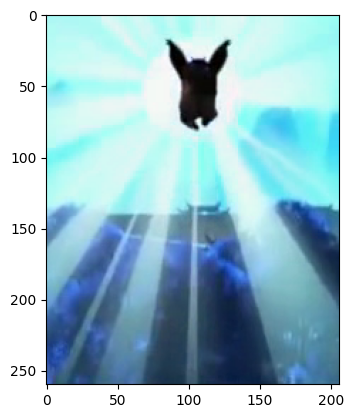

In [88]:
plt.imshow(cropped_frame)
plt.show()

### 1.5 Overlay the First Frame of the Two Videos

In this step, you should replace the computer vision book in the first video frame with the first cropped frame of the movie video to make the AR Effect.

In [89]:
def create_polygon_mask(image_shape, polygon_corners):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    polygon_corners = np.array([polygon_corners], dtype=np.int32)
    cv2.fillPoly(mask, polygon_corners, 255)
    return mask

In [90]:
def overlay_cropped_frame(background_frame, cropped_frame, book_corners):
    book_width = int(np.linalg.norm(book_corners[1] - book_corners[0]))
    book_height = int(np.linalg.norm(book_corners[3] - book_corners[0]))
    cropped_frame_resized = cv2.resize(cropped_frame, (book_width, book_height))
    dst_pts = np.array([[book_corners[0][0], book_corners[0][1]],
                        [book_corners[1][0], book_corners[1][1]],
                        [book_corners[3][0], book_corners[3][1]],
                        [book_corners[2][0], book_corners[2][1]]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(np.float32([[0, 0], [book_width, 0], [0, book_height], [book_width, book_height]]), dst_pts)
    warped_cropped_frame = cv2.warpPerspective(cropped_frame_resized, M, (background_frame.shape[1], background_frame.shape[0]))
    mask = create_polygon_mask(background_frame.shape, book_corners)
    mask_colored = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    result_frame = cv2.bitwise_and(background_frame, cv2.bitwise_not(mask_colored))
    result_frame += cv2.bitwise_and(warped_cropped_frame, mask_colored)
    return result_frame

In [91]:
result_frame = overlay_cropped_frame(video_frame, cropped_frame, book_corners_video)


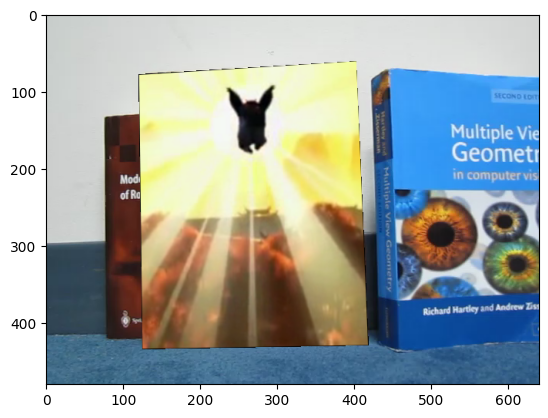

In [92]:
plt.imshow(cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB))
plt.show()

### 1.6 Creating AR Application

To create the final video, you need to repeat step 1.4 and overlay each cropped video frame to its corresponding frame of the book video. To do this you need to get the new location of the book in the following frame. This will be done by computing the homography matrix between each 2 consecutive frames or between the vision book cover and all the frames.
With this done, the book corners in each frames can be calculated and the movie frames can be overlayed as mentioned in step 1.4

In [93]:
def ar_app(book_image_path, video_path, ar_video_path):
    result_frames = []
    book_image = cv2.imread(book_image_path, cv2.IMREAD_GRAYSCALE)
    frames = extract_frames(video_path)
    ar_frames = extract_frames(ar_video_path)
    min_frames = min(len(frames), len(ar_frames))
    for i in range(min_frames):
        video_frame = frames[i]
        ar_frame = ar_frames[i]
        video_frame_gray = cv2.cvtColor(video_frame, cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create()
        keypoints_book, descriptors_book = sift.detectAndCompute(book_image, None)
        keypoints_video, descriptors_video = sift.detectAndCompute(video_frame_gray, None)
        brute_force = cv2.BFMatcher()
        matches = brute_force.knnMatch(descriptors_book, descriptors_video, k=2)
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        good_matches = sorted(good_matches, key=lambda x: x.distance)
        selected_matches = good_matches[:50]
        correspondences = []
        for i in range(10):
            x, y = keypoints_book[selected_matches[i].queryIdx].pt
            xp, yp = keypoints_video[selected_matches[i].trainIdx].pt
            correspondences.append((x, y, xp, yp))
        homography_matrix = compute_homography_matrix(correspondences)
        book_corners_video = detect_book_corners(homography_matrix)
        black_bars = 50
        source_video = ar_frame[black_bars:-black_bars,]
        cropped_frame = crop_frame(source_video)
        result_frame = overlay_cropped_frame(video_frame, cropped_frame, book_corners_video)
        result_frames.append(result_frame)
    return result_frames

In [94]:
def frames_to_video(frames, output_path, fps=30):
    height, width, layers = frames[0].shape
    size = (width, height)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Adjust codec as needed
    out = cv2.VideoWriter(output_path, fourcc, fps, size)
    for frame in frames:
        out.write(frame)
    out.release()

In [95]:
result = ar_app('cv_cover.jpg', 'book.mov', 'ar_source.mov')
frames_to_video(result, 'output_video.mp4', fps=30)

## 2. Part 2: Image Mosaics

### 2.1 Getting Correspondences and Compute the Homography Parameters

The first steps of this part is the same as 1.1 and 1.2. We will follow the same steps to get the correspondences and the homography matrix.

In [96]:
pan_image1 = cv2.imread('pano_image2.jpg')
pan_image2 = cv2.imread('pano_image1.jpg')

In [97]:
ky1, des1, ky2, des2 = get_keypoints_and_descriptors(pan_image1, pan_image2)
matches = get_best_matches(des1, des2)

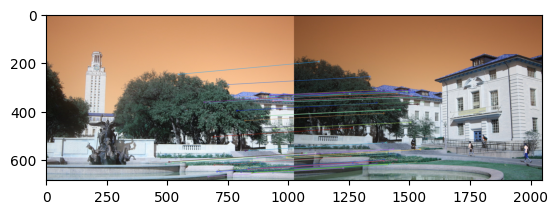

In [98]:
img_matches = cv2.drawMatches(pan_image1, ky1, pan_image2, ky2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches)
plt.show()

[(718.3132934570312, 646.9342651367188, 254.8863067626953, 611.8441162109375), (936.5043334960938, 652.2306518554688, 464.7881774902344, 616.0808715820312), (870.4649658203125, 349.93817138671875, 424.169921875, 325.0363464355469), (889.96630859375, 634.2447509765625, 422.8000793457031, 599.1375122070312), (928.0873413085938, 335.49005126953125, 478.88916015625, 315.0970764160156), (557.571044921875, 608.7946166992188, 88.26390075683594, 572.8262329101562), (821.3084106445312, 437.98297119140625, 370.42431640625, 407.9187927246094), (928.0873413085938, 335.49005126953125, 478.88916015625, 315.0970764160156), (876.972412109375, 649.1998901367188, 409.8143005371094, 613.685546875), (949.0458984375, 340.0861511230469, 497.2711486816406, 320.55926513671875)]


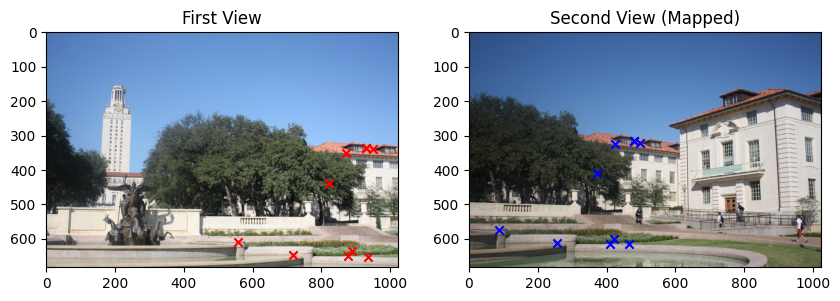

In [99]:
correspondences = []
for i in range(10):
    x, y = ky1[matches[i].queryIdx].pt
    xp, yp = ky2[matches[i].trainIdx].pt
    correspondences.append((x, y, xp, yp))
homography_matrix = compute_homography_matrix(correspondences)
print(correspondences)
verify_homography(correspondences, homography_matrix, pan_image1, pan_image2)

### 2.2 Warping Between Image Planes

Write a function that can take the recovered homography matrix and an image, and return a new image that is the warp of the input image using H . Since the transformed coordinates will typically be sub-pixel values, we can solve this by rounding the resulting coordinates or by distributing the pixel value to the nearby destination pixels. For the later case the destination pixel value is the average of any pixel values that maps to it. For color images, warp each RGB channel separately and then stack together to form the output.

To avoid holes in the output, use an inverse warp. Warp the points from the result image into the image before the warping, and compute the bounding box in the source image. Then sample all points in that destination bounding box from the proper coordinates in the source image (linear interpolation). Note that transforming all the points will generate an image of a different shape/dimensions than the original input.

In [100]:
def get_coordinates(image):
    coordinates = []
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            point = [x, y, 1]
            coordinates.append(point)
    return np.array(coordinates)

In [101]:
def forward_warp(image, homography_matrix):
    result = np.zeros(image.shape, dtype=np.uint8)
    coordinates = get_coordinates(image)
    wrapped = np.dot(homography_matrix, coordinates.T).T
    wrapped = wrapped / wrapped[:, 2:]
    wrapped = np.floor(wrapped).astype(int)
    for i in range(len(wrapped)):
        xp = wrapped[i][0]
        yp = wrapped[i][1]
        x = coordinates[i][0]
        y = coordinates[i][1]
        if xp >= 0 and xp < result.shape[1] and yp >= 0 and yp < result.shape[0]:
            result[yp][xp] = image[y][x]
    return result

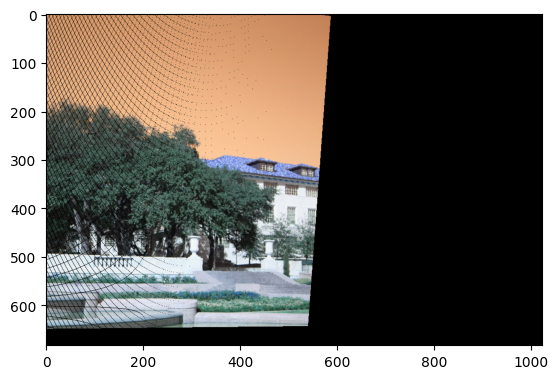

In [102]:
forward_wrap_result = forward_warp(pan_image1,homography_matrix)
plt.imshow(forward_wrap_result)
plt.show()

In [103]:
def inverse_warp(image, H):
    height, width = image.shape[:2]
    inverse_warped = np.zeros_like(image)
    coordinates = get_coordinates(image)
    h_inv = np.linalg.inv(H)
    wrapped = np.dot(h_inv, coordinates.T).T
    wrapped = wrapped / wrapped[:, 2:]
    min_x = np.min(wrapped[:, 0])
    min_y = np.min(wrapped[:, 1])
    offset_x = min_x
    offset_y = min_y
    if (min_x < 0):
        min_x = -min_x
    if (min_y < 0):
        min_y = -min_y
    for y in range(height):
        for x in range(width):
            p_transformed = np.dot(np.linalg.inv(H), np.array([x, y, 1]))
            u_normalized = (p_transformed[0] / p_transformed[2]) - min_x
            v_normalized = (p_transformed[1] / p_transformed[2]) - min_y
            if 0 <= u_normalized < width - 1 and 0 <= v_normalized < height - 1:
                u_int, v_int = int(u_normalized), int(v_normalized)
                u_frac, v_frac = u_normalized - u_int, v_normalized - v_int
                pixel_value = (1 - u_frac) * (1 - v_frac) * image[v_int, u_int] + \
                              u_frac * (1 - v_frac) * image[v_int, u_int + 1] + \
                              (1 - u_frac) * v_frac * image[v_int + 1, u_int] + \
                              u_frac * v_frac * image[v_int + 1, u_int + 1]
                inverse_warped[y, x] = pixel_value.astype(np.uint8)
    return inverse_warped, offset_x, offset_y

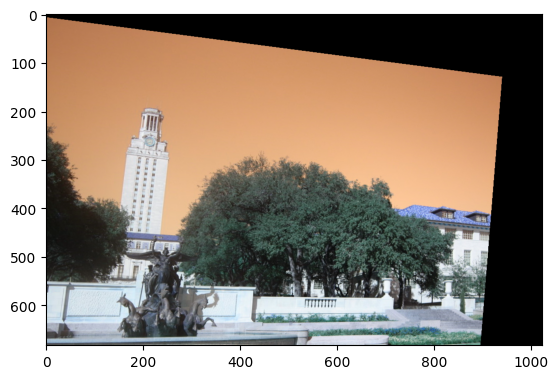

In [104]:
invesre_wrap_results, _, _ = inverse_warp(pan_image1, homography_matrix)
plt.imshow(invesre_wrap_results)
plt.show()

### 2.3 Create the output mosaic

Once we have the source image warped into the destination images frame of reference, we can create a merged image showing the mosaic. Create a new image large enough to hold both (registered) views; overlay one view onto the other, simply leaving it black wherever no data is available. Do not worry about artifacts that result at the boundaries.

In [105]:
def create_mosaic(image1, image2, homography_matrix):
    warped_image, offset_x, offset_y = inverse_warp(image1, homography_matrix)
    offset_x = abs(int(offset_x))
    offset_y = abs(int(offset_y))
    width = image2.shape[1] + (offset_x)
    height = image2.shape[0] + (offset_y)
    mosaic = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(image2.shape[0]):
        for j in range(image2.shape[1]):
            mosaic[i+offset_y][j+offset_x] = image2[i][j]
    for i in range(warped_image.shape[0]):
        for j in range(warped_image.shape[1]):
            if np.all(warped_image[i][j] != 0):
                mosaic[i][j] = warped_image[i][j]
    return mosaic

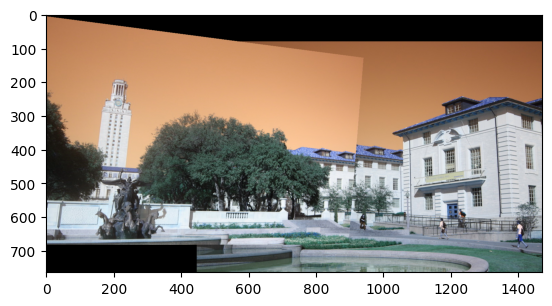

In [106]:
mosaic= create_mosaic(pan_image1, pan_image2, homography_matrix)
plt.imshow(mosaic)
plt.show()

## 3. Bonus


Instead of stitching 2 images, stitch 3 images that overlap with each other.
- Stitch 2 images together following the previous steps.
- Get correspondences between the output of stitching the 2 first images and the third image Note: The order of stitc.
- Stitch the output with the third image creating the final output 

Note: The order of stitching yields different results.

In [107]:
shan_image1 = cv2.imread('shanghai-21.png')
shan_image2 = cv2.imread('shanghai-22.png')
shan_image3 = cv2.imread('shanghai-23.png')

ky1, des1, ky2, des2 = get_keypoints_and_descriptors(shan_image1, shan_image2)
matches = get_best_matches(des1, des2)
correspondences = []
for i in range(10):
    x, y = ky1[matches[i].queryIdx].pt
    xp, yp = ky2[matches[i].trainIdx].pt
    correspondences.append((x, y, xp, yp))
homography = compute_homography_matrix(correspondences)
image12 = create_mosaic(shan_image1, shan_image2,homography)

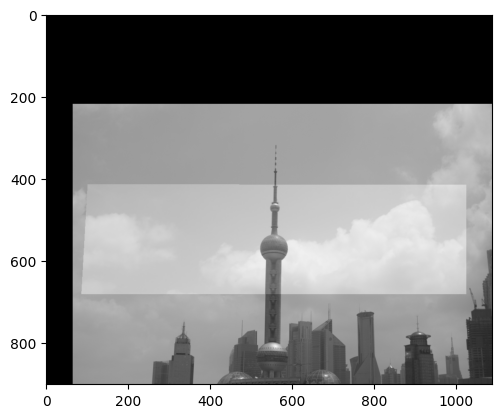

In [108]:
plt.imshow(image12)
plt.show()

In [109]:
ky1, des1, ky2, des2 = get_keypoints_and_descriptors(image12,shan_image3 )
matches = get_best_matches(des1, des2)
correspondences = []
for i in range(10):
    x, y = ky1[matches[i].queryIdx].pt
    xp, yp = ky2[matches[i].trainIdx].pt
    correspondences.append((x, y, xp, yp))
homography = compute_homography_matrix(correspondences)
image123 = create_mosaic(image12, shan_image3,homography)

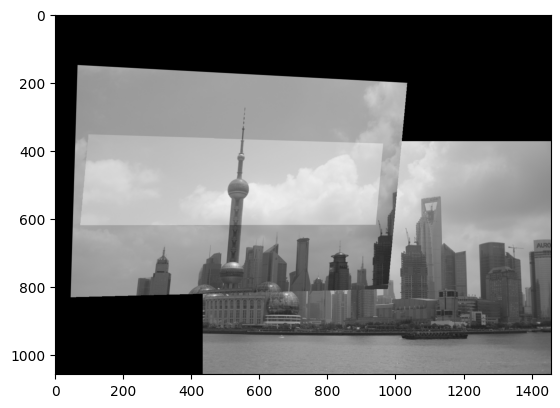

In [110]:
plt.imshow(image123)
plt.show()